<div class="alert alert-block alert-info" style='text-align:center'>
    Experiment begins here
</div>

# Notebook structure
1. [Packages used](#Import-packages)
2. [Some utilities](#Some-utilities)
3. [Dataset management](#Dataset)
4. [Modeling](#Modeling)
5. [Training pipeline](#Training-pipeline)
6. [Prediction time](#Prediction-time)

## Import packages

In [1]:
import sys
sys.path.append('../scripts')

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from dataset import DataSet, DataModule
from model import Model, Model1
from utils import ramp_scheduler
from config import Config

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch as th

import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, GPUStatsMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.utils.class_weight import compute_class_weight

from tqdm.notebook import tqdm

from transformers import AutoTokenizer

## Some utilities

In [4]:
_ = seed_everything(Config.seed_value)

Global seed set to 2021


In [5]:
epochs = [x for x in range(100)]
lrs = [ramp_scheduler(epoch = x) for x in epochs]

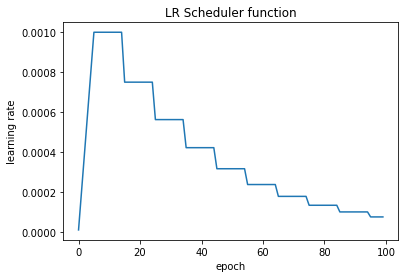

In [6]:
plt.title('LR Scheduler function')
plt.plot(epochs, lrs)
plt.xlabel('epoch')
plt.ylabel('learning rate')

plt.show()

<div class="alert alert-block alert-info" style='text-align:center' id="Dataset">
   Dataset
</div>

In [7]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'Train_10_folds.csv'))
train_df.head()

,ID,text,label,fold
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,7
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,9
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,7
3,U0TTYY8,ak slouma,1,6
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,4


In [8]:
%%time
dm = DataModule(
    df=train_df,
    frac=1,
    train_batch_size= Config.train_batch_size,
    test_batch_size= Config.test_batch_size,
    test_size = .2
)

dm.setup()

[INFO] Training on 56000 samples belonging to 3 classes
[INFO] Validating on 14000 samples belonging to 3 classes
CPU times: user 242 ms, sys: 12.1 ms, total: 254 ms
Wall time: 262 ms


## Model part

<div class="alert alert-block alert-info" style='text-align:center' id="Modeling">
   Modeling
</div>

### 1- Class weights computation

In [9]:
%%time

# compute class weights
class_w = compute_class_weight(
    class_weight='balanced', 
    classes=train_df.label.unique(), 
    y=train_df.label.values
)
class_w = th.from_numpy(class_w).float()
class_w

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 12.1 ms


tensor([0.7965, 0.6102, 9.4620])

### 2- Model definition

In [10]:
%%time

tokenizer = AutoTokenizer.from_pretrained(Config.base_model)

# define model
model = Model1(
    class_w=None,
    tokenizer=tokenizer
)

print(model.encoder)
try:
    print(model.decoder)
except:
    print(model.classifier)


GRU(100, 300, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)
Linear(in_features=600, out_features=3, bias=True)
CPU times: user 238 ms, sys: 23.2 ms, total: 261 ms
Wall time: 261 ms


## Training config/setup

<div class="alert alert-block alert-info" style='text-align:center' id="Training-pipeline">
   Training pipeline
</div>

### 1- Calbacks definition

In [11]:
model_ckpt = ModelCheckpoint(
    filename=os.path.join(
        Config.models_dir, f"arabizi-sentiments-{Config.base_model}"),
    monitor='val_acc',
    mode="max"
)
es = EarlyStopping(
    monitor='val_acc',
    patience=Config.early_stopping_patience,
    mode="max"
)
gpu_stats = GPUStatsMonitor(
    memory_utilization=True,
    gpu_utilization=True,
    intra_step_time=False,
    inter_step_time=False,
    fan_speed=True,
    temperature=True,
)

callbacks_list = [es, model_ckpt, gpu_stats]


### 2- Logger definition

In [12]:
walk = sorted([folder for folder in os.listdir(os.path.join(Config.logs_dir, 'zindi-arabizi')) if len(folder.split('.'))<=1])

if len(walk) > 0:
    version = int(walk[-1].split('_')[-1]) +1
else:
    version = 0
    
tb_logger = TensorBoardLogger(
    save_dir=Config.logs_dir,
    name='zindi-arabizi',
    default_hp_metric=False
)
# save experiment config

with open(os.path.join(Config.logs_dir, 'zindi-arabizi',f'conf-exp-{version}.txt'), 'w') as conf:
    conf.write(f'================== Config file version {version} ===================\n\n')
    d = dict(Config.__dict__)
    conf_dict = {k:d[k] for k in d.keys() if '__' not in k}
    
    for k in conf_dict:
        v = conf_dict[k]
        conf.write(f'{k} : {v}\n')
    

### 3- Trainer definition

In [13]:
trainer = Trainer(
    logger=tb_logger, 
    checkpoint_callback=True, 
    gpus=1,
    #fast_dev_run=True,
    min_epochs=2,
    max_epochs=Config.num_epochs,
    precision=32,
    callbacks=callbacks_list
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


<div class="alert alert-block alert-info" style='text-align:center' id="Training-job">
   Training job
</div>

In [ ]:
trainer.fit(
    model=model, 
    datamodule=dm
)


  | Name       | Type      | Params
-----------------------------------------
0 | embedding  | Embedding | 12.0 M
1 | encoder    | GRU       | 4.0 M 
2 | classifier | Linear    | 1.8 K 
3 | dropout    | Dropout   | 0     
-----------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.710    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<div class="alert alert-block alert-info" style='text-align:center' id="Prediction-time">
   Prediction time
</div>

In [ ]:
try:
    th.jit.save(
        model.to_torchscript(),
        os.path.join(
            Config.models_dir, 
            f'arabizi-sentiments-{Config.base_model}-version-{version}.bin'
        )
    )
except Exception as e:
    print("[ERROR]", e)